# Block 9: Linear Binary Classification

In [1]:
import numpy as np 
import pandas as pd 
from typing import List
import jax.numpy as jnp 
import jax
import matplotlib.pyplot as plt

In [2]:
def forward_fn(Beta, X):
    f = X @ Beta 
    p = 1/(1+jnp.exp(-f))
    return p 

def loss_fn(Beta, X, y):
    p = forward_fn(Beta, X)
    loss = -jnp.mean(y * jnp.log(p) + (1-y) * jnp.log(1-p))
    return loss 

class BinaryLinearModel():

    def __init__(self, 
                 features: List[str]):
        self._features = features 
    
    def train(self, rng, 
              df: pd.DataFrame, 
              y: np.ndarray, 
              epochs: int = 100, 
              eta: float = 0.01, 
              batch_size: int = 100000):
        grad_fn = jax.grad(loss_fn)

        y = jnp.array(y)
        
        # prepare inputs and outputs
        X = self._prepare_input_matrix(df[self._features])
        
        # randomly initialize solution 
        Beta = jax.random.normal(rng, X.shape[1]) # K

        # iterate for epochs
        history = []
        for i in range(epochs):

            # shuffle dataset (important)
            loop_key = jax.random.fold_in(rng, i)
            ix = jax.random.permutation(loop_key, X.shape[0])
            X = X[ix, :]
            y = y[ix]

            # go over mini batches and update
            for j in range(0, X.shape[0], batch_size):
                offset = j 
                end = j + batch_size

                # compute gradient
                # this is very powerful ... JAX takes care of derivative computation
                # so loss_fn could be as complex as you like
                Beta_grad = grad_fn(Beta, X[offset:end,:], y[offset:end])
                
                # update solution
                Beta = Beta - eta * Beta_grad

            # record epoch loss
            mse = loss_fn(Beta, X, y)
            history.append([Beta, mse])

        # save the parameters
        self._params, _ = history[-1]

        return history
    
    def _prepare_input_matrix(self, df: pd.DataFrame):

        # we need to separate categorical from numeric features
        # because they require separate processing
        # let's get categorical columns
        categorical_cols = df.select_dtypes(include='object').columns
        
        # let's get numeric
        ordinal_cols = df.select_dtypes(include='number').columns

        # construct input features
        X = df[ordinal_cols].to_numpy()

        # z-score (NxK' - 1xK') / 1xK' = NxK'
        X = (X - np.mean(X, axis=0)[None, :]) / np.std(X, axis=0)[None, :]

        # code categorical features
        for feature in categorical_cols:
            dummies = pd.get_dummies(df[feature]).to_numpy().astype(float)
            X = np.hstack((X, dummies)) 

        # add a column of ones
        ones_col = np.ones((X.shape[0], 1)) # Nx1
        X = np.hstack((ones_col, X)) # K
        
        return jnp.array(X) 
    
    def predict(self, df: pd.DataFrame):
         
        X = self._prepare_input_matrix(df[self._features])

        return forward_fn(self._params, X)
    
df = pd.read_csv("../data/separable_binary_data.csv")
df

model = BinaryLinearModel(['x1', 'x2'])

rng = jax.random.key(52345)

history = model.train(rng, df, df['y'].to_numpy(), epochs=100, eta=0.1, batch_size=100)

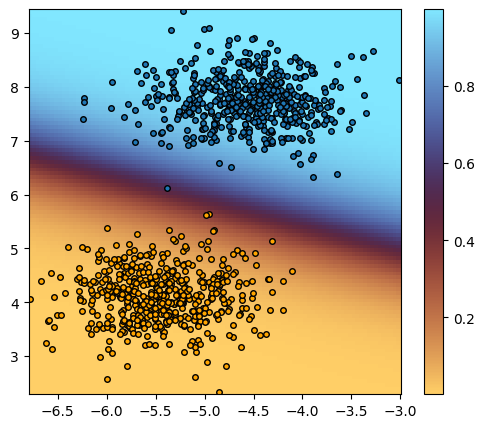

In [3]:
# initialize range of input values

min_x = np.min(df[['x1', 'x2']].to_numpy(), axis=0)
max_x = np.max(df[['x1', 'x2']].to_numpy(), axis=0)

K = 100
x1s = np.linspace(min_x[0], max_x[0], K)
x2s = np.linspace(min_x[1], max_x[1], K)
x1s, x2s = np.meshgrid(x1s, x2s)

# zip the inputs up into a (K*K, 2) array
Xstar = np.vstack((x1s.flatten(), x2s.flatten())).T

df_star = pd.DataFrame(data=Xstar, columns=['x1','x2'])

yhat = model.predict(df_star).reshape((K,K))

f, ax = plt.subplots(1, 1, figsize=(6, 5))

cp = ax.pcolor(x1s, x2s, yhat, cmap=plt.get_cmap('managua')) # 0: orange, 1: blue
f.colorbar(cp)

#
# plot the actual points
#
X = df[['x1','x2']].to_numpy()

y = df['y'].to_numpy()
class0_ix = y == 1 # y = 1, blue
class1_ix = y == 0 # y = 0, orange

ax.plot(X[class0_ix, 0], X[class0_ix, 1], marker='o', markersize=4, linestyle='', markeredgecolor='black', markeredgewidth=1)
ax.plot(X[class1_ix, 0], X[class1_ix, 1], color='orange', marker='o', markersize=4, linestyle='', markeredgecolor='black', markeredgewidth=1)


# A Hard Example

In [4]:
df = pd.read_csv("../data/nonseparable_binary_data.csv")
df

model = BinaryLinearModel(['x1', 'x2'])

rng = jax.random.key(52345)

history = model.train(rng, df, df['y'].to_numpy(), epochs=100, eta=0.1, batch_size=100)

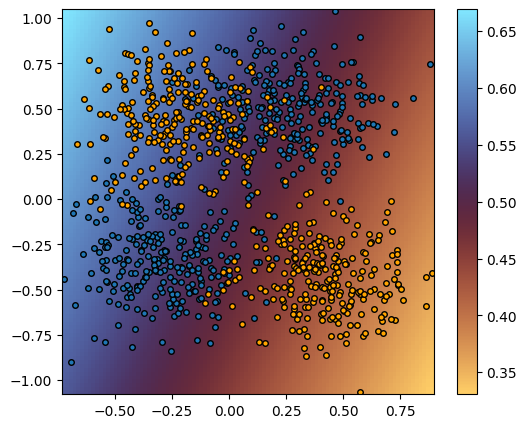

In [5]:
# initialize range of input values

min_x = np.min(df[['x1', 'x2']].to_numpy(), axis=0)
max_x = np.max(df[['x1', 'x2']].to_numpy(), axis=0)

K = 100
x1s = np.linspace(min_x[0], max_x[0], K)
x2s = np.linspace(min_x[1], max_x[1], K)
x1s, x2s = np.meshgrid(x1s, x2s)

# zip the inputs up into a (K*K, 2) array
Xstar = np.vstack((x1s.flatten(), x2s.flatten())).T

df_star = pd.DataFrame(data=Xstar, columns=['x1','x2'])

yhat = model.predict(df_star).reshape((K,K))

f, ax = plt.subplots(1, 1, figsize=(6, 5))

cp = ax.pcolor(x1s, x2s, yhat, cmap=plt.get_cmap('managua')) # 0: orange, 1: blue
f.colorbar(cp)

#
# plot the actual points
#
X = df[['x1','x2']].to_numpy()

y = df['y'].to_numpy()
class0_ix = y == 1 # y = 1, blue
class1_ix = y == 0 # y = 0, orange

ax.plot(X[class0_ix, 0], X[class0_ix, 1], marker='o', markersize=4, linestyle='', markeredgecolor='black', markeredgewidth=1)
ax.plot(X[class1_ix, 0], X[class1_ix, 1], color='orange', marker='o', markersize=4, linestyle='', markeredgecolor='black', markeredgewidth=1)
